In [18]:
%matplotlib inline
%load_ext Cython 
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [19]:
%%cython
cimport cython
from cython.parallel import prange
from libc.math cimport sqrt, pow, exp
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
@cython.wraparound(False)

cdef class Periodic_2D:
    cdef int Np
    
    cdef int [:] active
       
    cdef double box_length
    cdef int max_box_lengths
    
    cdef int periodic
    
    cdef double vp
    cdef double epsilon_LJ
    cdef double kbT,diam, visc
    cdef double zeta_T_passive, zeta_T_active, zeta_R_active
    cdef double Dc,k
    cdef double flow_uniform, flow_shear
    
    cdef double mu
    cdef double Dt
    cdef double Dr
    
    cdef double LJ_range, LJ_coeff_T
    cdef double diff_coeff_T_passive, diff_coeff_T_active, diff_coeff_R_active
    cdef double noise_coeff_T, noise_coeff_R
    cdef double HI_coeff_T, HI_coeff_R
    
    cdef double [:] r_periodic_x
    cdef double [:] r_periodic_y
    
    cdef double max_v
    cdef double max_idr

    def __init__(self, Np, active, box_length, max_box_lengths,max_v, periodic,
                 vp, epsilon_LJ, kbT, diam, visc,
                 zeta_T_passive, zeta_T_active, zeta_R_active,
                 Dc, k, flow_uniform, flow_shear):
        
        self.Np=Np
        self.active=active
        self.box_length=box_length
        self.max_box_lengths=max_box_lengths
        self.max_v=max_v
        self.vp=vp
        self.epsilon_LJ=epsilon_LJ
        self.kbT=kbT
        self.diam=diam
        self.visc=visc
        self.zeta_T_passive=zeta_T_passive
        self.zeta_T_active=zeta_T_active
        self.zeta_R_active=zeta_R_active
        self.Dc=Dc
        self.k=k
        self.flow_uniform=flow_uniform
        self.flow_shear=flow_shear
        
        if periodic:
            self.periodic=int(1)
        else:
            self.periodic=int(0)

        self.mu=2.0/(6*3.14159265359*self.visc*self.diam)
        self.Dt=self.kbT*self.mu
        self.Dr=3*self.Dt/pow(self.diam,2)
        
        self.LJ_range = self.diam  
        self.LJ_coeff_T = 12*self.mu*self.epsilon_LJ*pow(self.diam,6)
        
        self.diff_coeff_T_passive=-1*self.zeta_T_passive*self.k*self.diam/(4* 3.14159265359*self.Dc)
        self.diff_coeff_T_active=-1*self.zeta_T_active*self.k*self.diam/(4* 3.14159265359*self.Dc)
        self.diff_coeff_R_active=-1*self.zeta_R_active*self.k*self.diam/(4* 3.14159265359*self.Dc)
        

        self.noise_coeff_T=sqrt(2*self.Dt)
        self.noise_coeff_R=sqrt(2*self.Dr)
        
        self.HI_coeff_T=pow(self.diam,3)*self.vp/16
        self.HI_coeff_R=pow(self.diam,3)*self.vp/32
        
        self.r_periodic_x = np.zeros(8*self.Np, dtype=np.float64)
        self.r_periodic_y = np.zeros(8*self.Np, dtype=np.float64)
        
        self.max_idr=self.calculate_max_idr()
        
    cpdef calculate_max_idr(self):
        
        cdef double diam=self.diam 
        cdef double diam6 = pow(self.diam,6) 
        cdef double max_v = self.max_v
        cdef double LJ_coeff_T=self.LJ_coeff_T
        cdef double dr = self.diam 
        cdef double v = 0.0
        cdef double max_idr
        
        
        while v < max_v:
            
            max_idr=1/dr
            idr13=pow(max_idr,13)
            idr7=pow(max_idr,7)
            v=5*LJ_coeff_T*(diam6*idr13-idr7)
            dr = dr - 0.00001*diam
        
        return max_idr            
    
    cpdef unitcellposition(self, double [:] r):
        
        cdef int Np = self.Np
        cdef int i
        cdef int counter
        cdef int max_box_lengths=self.max_box_lengths
        cdef double box_length = self.box_length
        cdef double box_length_half=box_length/2
        cdef double box_length_half_neg = -1*box_length_half
        
        for i in prange(2*Np, nogil=True):
            if r[i] > box_length_half:
                for counter in range(max_box_lengths):
                    if r[i]>box_length_half:
                        r[i]= r[i]-box_length
            elif r[i] < box_length_half_neg:
                for counter in range(max_box_lengths):
                    if r[i] < box_length_half_neg:
                        r[i]= r[i]+box_length

    cpdef reflectedcellposition(self, double [:] r):
        
        cdef int Np=self.Np, i
        cdef double box_length = self.box_length
        cdef double [:] r_periodic_x = self.r_periodic_x
        cdef double [:] r_periodic_y = self.r_periodic_y
        
        for i in prange(Np, nogil=True):
            r_periodic_x[i] = r[i]-box_length
            r_periodic_x[i+Np] = r[i]-box_length
            r_periodic_x[i+2*Np] = r[i]-box_length
            r_periodic_x[i+3*Np] = r[i]
            r_periodic_x[i+4*Np] = r[i]
            r_periodic_x[i+5] = r[i]+box_length
            r_periodic_x[i+6*Np]= r[i]+box_length
            r_periodic_x[i+7*Np]= r[i]+box_length
            
            r_periodic_y[i] = r[i+Np]+box_length
            r_periodic_y[i+Np] = r[i+Np]
            r_periodic_y[i+2*Np] = r[i+Np]-box_length
            r_periodic_y[i+3*Np] = r[i+Np]+ box_length
            r_periodic_y[i+4*Np] = r[i+Np]- box_length
            r_periodic_y[i+5] = r[i+Np]+box_length
            r_periodic_y[i+6*Np]= r[i+Np]
            r_periodic_y[i+7*Np]= r[i+Np]-box_length
            
            
    cpdef Self_Propel_T (self, double [:] v, double [:] p):

        cdef int Np = self.Np, i
        cdef double vp= self.vp
        cdef int [:] active = self.active
        
        for i in prange(Np,nogil=True):
            if active[i]==1:
                v[i] += p[i]*vp
                v[i+Np] += p[i+Np]*vp
            
        return
            
    cpdef LJ_T (self, double [:] v, double [:] r):

        cdef int Np = self.Np, i, j
        cdef double LJ_range2=self.LJ_range*self.LJ_range
        cdef double LJ_coeff_T=self.LJ_coeff_T
        cdef double diam6=pow(self.diam,6)
        
        cdef double dx, dy, idr, dr2, vx, vy, fac, idr14,idr8
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
        
        for i in prange(Np,nogil=True):
            for j in range(i,Np):
                dx = r[i   ] - r[j   ]
                dy = r[i+Np] - r[j+Np]
                dr2 = dx*dx + dy*dy 
                if i != j and dr2 <= (LJ_range2):
                    idr = 1.0/sqrt(dr2)
                    if idr>max_idr:
                        idr=max_idr
                    idr14=pow(idr,14)
                    idr8=pow(idr,8)
                    
                    fac= LJ_coeff_T*(diam6*idr14-idr8)

                    v[i] += fac*dx
                    v[i+Np] += fac*dy
                    
                    v[j] += -1*fac*dx
                    v[j+Np] += -1*fac*dy
        
            if periodic==1:
                for k in range(8*Np):
                    dx = r[i   ] - r_periodic_x[k  ]
                    dy = r[i+Np] - r_periodic_y[k  ]
                    dr2 = dx*dx + dy*dy 
                    if dr2 <= (LJ_range2):
                        idr = 1.0/sqrt(dr2)
                        if idr>max_idr:
                            idr=max_idr
                        idr14=pow(idr,14)
                        idr8=pow(idr,8)
                    
                        fac= LJ_coeff_T*(diam6*idr14-idr8)

                        v[i] += fac*dx
                        v[i+Np] += fac*dy
            
        return
    
    cpdef Noise_T (self, double [:] v):

        cdef int Np = self.Np, i
        cdef double [:] Noise= np.random.normal(size=2*Np, scale=1)
        cdef double noise_coeff_T=self.noise_coeff_T
        
        for i in prange(Np,nogil=True):
            v[i] += noise_coeff_T*Noise[i]
            v[i+Np] += noise_coeff_T*Noise[i+Np]
            
        return
    
    cpdef Noise_R (self, double [:] dpdt, double [:] p):

        cdef int Np = self.Np, i
        
        cdef int [:] active = self.active
        cdef double [:] Noise= np.random.normal(size=Np, scale=1)
        cdef double noise_coeff_R=self.noise_coeff_R
        
        for i in prange(Np,nogil=True):
            if active[i]==1:
                dpdt[i] += -1*noise_coeff_R*Noise[i]*p[i+Np]
                dpdt[i+Np] += noise_coeff_R*Noise[i]*p[i]
            
        return


    cpdef HI_T (self, double [:] v, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,    
        cdef double dx, dy, idr, idr3, idr5, Ddotidr

        cdef int [:] active = self.active
        cdef double HI_coeff_T = self.HI_coeff_T
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
        
        for i in prange(Np, nogil=True):  
            for j in range(i,Np):
                if i != j: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    if idr>max_idr:
                        idr=max_idr
                    idr3 = idr*idr*idr
                    idr5=idr3*idr*idr
                    
                    if active[j]==1:
                        Ddotidr = (p[j]*dx + p[j+Np]*dy )
                        v[i] += HI_coeff_T*(3*idr5*Ddotidr*dx-idr3*p[j])
                        v[i+Np] += HI_coeff_T*(3*idr5*Ddotidr*dy-idr3*p[j+Np])
                    if active[i]==1:
                        Ddotidr = (p[i]*dx + p[i+Np]*dy )
                        v[j] += HI_coeff_T*(3*idr5*Ddotidr*dx-idr3*p[i])
                        v[j+Np] += HI_coeff_T*(3*idr5*Ddotidr*dy-idr3*p[i+Np])
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = r[ i]   - r_periodic_x[k]
                        dy = r[i+Np] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        if idr>max_idr:
                            idr=max_idr
                        idr3 = idr*idr*idr
                        idr5=idr3*idr*idr
                        Ddotidr = (p[j]*dx + p[j+Np]*dy )

                        v[i] += HI_coeff_T*(3*idr5*Ddotidr*dx-idr3*p[j])
                        v[i+Np] += HI_coeff_T*(3*idr5*Ddotidr*dy-idr3*p[j+Np])
            
        return 

    cpdef HI_R (self, double [:] dpdt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr7, g

        cdef int [:] active = self.active
        cdef double HI_coeff_R = self.HI_coeff_R
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
        
        for i in prange(Np, nogil=True):
            for j in range(i,Np):
                if i != j and active[i]==1 and active[j]==1: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    if idr>max_idr:
                        idr=max_idr
                    idr7=pow(idr,7)
                    g=(-9*p[j]*dx*dx*dx-21*p[j+Np]*dx*dx*dy+21*p[j]*dx*dy*dy+9*p[j+Np]*dy*dy*dy)*idr7
                    dpdt[i] += -1*HI_coeff_R*g*p[i+Np]
                    dpdt[i+Np] += HI_coeff_R*g*p[i]
              
                    g=-1*(-9*p[i]*dx*dx*dx-21*p[i+Np]*dx*dx*dy+21*p[i]*dx*dy*dy+9*p[i+Np]*dy*dy*dy)*idr7
                    dpdt[j] += -1*HI_coeff_R*g*p[j+Np]
                    dpdt[j+Np] += HI_coeff_R*g*p[j]
                        
            
                if periodic==1:
                    for k in range(8*Np):
                        j = k % Np
                        if active[j]==1:
                            dx = r[ i]   - r_periodic_x[k]
                            dy = r[i+Np] - r_periodic_y[k] 
                            idr = 1.0/sqrt( dx*dx + dy*dy )
                            if idr>max_idr:
                                idr=max_idr
                            idr7=pow(idr,7)
                            g=(-9*p[j]*dx*dx*dx-21*p[j+Np]*dx*dx*dy+21*p[j]*dx*dy*dy+9*p[j+Np]*dy*dy*dy)*idr7
                    
                            dpdt[i] += -1*HI_coeff_R*g*p[i+Np]
                            dpdt[i+Np] += HI_coeff_R*g*p[i]
        
        return 
    
    cpdef Flow_T (self, double [:] v, double [:] r):

        cdef int Np = self.Np, i  
        
        cdef double flow_uniform=self.flow_uniform
        cdef double flow_shear=self.flow_shear
        
        for i in prange(Np, nogil=True):
            v[i] += flow_uniform+flow_shear*r[i+Np]
            
        return 
    
    cpdef Flow_R (self, double [:] dpdt, double [:] p):

        cdef int Np = self.Np, i  
        
        cdef int [:] active = self.active
        cdef double flow_shear=self.flow_shear
        
        for i in prange(Np, nogil=True):
            if active[i]==1:
                dpdt[i] += 1/2*flow_shear*p[i+Np]
                dpdt[i+Np] += -1/2*flow_shear*p[i]
            
        return
    
    cpdef Phoresis_T (self, double [:] v, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3, vx, vy

        cdef int [:] active = self.active
        cdef double diff_coeff_T_passive = self.diff_coeff_T_passive
        cdef double diff_coeff_T_active=self.diff_coeff_T_active
        cdef double diff_coeff_T
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
        
        for i in prange(Np, nogil=True):
            for j in range(i, Np):
                if i != i: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    if idr>max_idr:
                        idr=max_idr
                    idr3 = idr*idr*idr
                    
                    if active[j]==1:
                        if active[i]==1:
                            diff_coeff_T=diff_coeff_T_active
                        else:
                            diff_coeff_T=diff_coeff_T_passive
                        v[i] += diff_coeff_T*idr3*dx
                        v[i+Np] += diff_coeff_T*idr3*dy
            
                    if active[i]==1:
                        if active[j]==1:
                            diff_coeff_T=diff_coeff_T_active
                        else:
                            diff_coeff_T=diff_coeff_T_passive
                        v[j] += -1*diff_coeff_T*idr3*dx
                        v[j+Np] += -1*diff_coeff_T*idr3*dy
                    
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = r[ i]   - r_periodic_x[k]
                        dy = r[i+Np] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        if idr>max_idr:
                            idr=max_idr
                        idr3 = idr*idr*idr

                        v[i] += diff_coeff_T*idr3*dx
                        v[i+Np] += diff_coeff_T*idr3*dy
            
        return
    
    
    cpdef Phoresis_R (self, double [:] dpdt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3

        cdef int [:] active = self.active
        cdef double diff_coeff_R_active=self.diff_coeff_R_active
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
        
        for i in prange(Np, nogil=True):  
            for j in range(i,Np):
                if i != j and active[j]==1 and active[i]==1: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    if idr>max_idr:
                        idr=max_idr
                    idr3 = idr*idr*idr
                    
                    dpdt[i] += diff_coeff_R_active*idr3*(p[i+Np]*p[i+Np]*dx-p[i]*p[i+Np]*dy)
                    dpdt[i+Np] += diff_coeff_R_active*idr3*(p[i]*p[i]*dy-p[i]*p[i+Np]*dx)

                    dpdt[j] += diff_coeff_R_active*idr3*-1*(p[j+Np]*p[j+Np]*dx-p[j]*p[j+Np]*dy)
                    dpdt[j+Np] += diff_coeff_R_active*idr3*-1*(p[j]*p[j]*dy-p[j]*p[j+Np]*dx)
            
            if periodic==1 and active[i]==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = r[ i]   - r_periodic_x[k]
                        dy = r[i+Np] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        if idr>max_idr:
                            idr=max_idr
                        idr3 = idr*idr*idr

                        dpdt[i] += diff_coeff_R_active*idr3*(p[i+Np]*p[i+Np]*dx-p[i]*p[i+Np]*dy)
                        dpdt[i+Np] += diff_coeff_R_active*idr3*(p[i]*p[i]*dy-p[i]*p[i+Np]*dx)

        return
    
    cpdef Field_HI (self, int Nt, double [:] vv, double [:] rt, double [:] r, double [:] p):

        cdef int Np = self.Np
        cdef int i, j
        cdef double dx, dy, idr, idr3, idr5, Ddotidr, vx, vy

        cdef int [:] active = self.active
        cdef double HI_coeff_T = self.HI_coeff_T
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
 
        for i in prange(Nt, nogil=True):
            vx =0.0; vy = 0.0; 
            for j in range(Np):
                if active[j]==1: 
                    dx = rt[ i]   - r[j]
                    dy = rt[i+Nt] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    if idr>max_idr:
                        idr=max_idr
                    idr3 = idr*idr*idr
                    idr5=idr3*idr*idr
                    Ddotidr = (p[j]*dx + p[j+Np]*dy )

                    vx += HI_coeff_T*(3*idr5*Ddotidr*dx-idr3*p[j])
                    vy += HI_coeff_T*(3*idr5*Ddotidr*dy-idr3*p[j+Np])
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = rt[ i]   - r_periodic_x[k]
                        dy = rt[i+Nt] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        if idr>max_idr:
                            idr=max_idr
                        idr3 = idr*idr*idr
                        idr5=idr3*idr*idr
                        Ddotidr = (p[j]*dx + p[j+Np]*dy )

                        vx += HI_coeff_T*(3*idr5*Ddotidr*dx-idr3*p[j])
                        vy += HI_coeff_T*(3*idr5*Ddotidr*dy-idr3*p[j+Np])
            
            vv[i]   += vx
            vv[i+Nt]+= vy
        return 
 
    cpdef Field_Flow (self, int Nt, double [:] vv, double [:] rt):

        cdef int i
        
        cdef double flow_uniform=self.flow_uniform
        cdef double flow_shear=self.flow_shear
        
        for i in prange(Nt, nogil=True):
            vv[i] += flow_uniform+flow_shear*rt[i+Nt]
            
        return
    
    cpdef Field_Phoresis_Active (self, int Nt, double [:] vv, double [:] rt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3, vx, vy

        cdef int [:] active = self.active
        cdef double diff_coeff_T=self.diff_coeff_T_active
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
        
        for i in prange(Nt, nogil=True):
            vx=0; vy=0;  
            for j in range(Np):
                if active[j]==1: 
                    dx = rt[ i]   - r[j]
                    dy = rt[i+Nt] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    if idr>max_idr:
                        idr=max_idr
                    idr3 = idr*idr*idr

                    vx += diff_coeff_T*idr3*dx
                    vy += diff_coeff_T*idr3*dy
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = rt[ i]   - r_periodic_x[k]
                        dy = rt[i+Nt] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        if idr>max_idr:
                            idr=max_idr
                        idr3 = idr*idr*idr

                        vx += diff_coeff_T*idr3*dx
                        vy += diff_coeff_T*idr3*dy
            
            vv[i]   += vx
            vv[i+Nt]+= vy
        return
    
    cpdef Field_Phoresis_Passive (self, int Nt, double [:] vv, double [:] rt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3, vx, vy

        cdef int [:] active = self.active
        cdef double diff_coeff_T=self.diff_coeff_T_passive
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        cdef double max_idr=self.max_idr
        
        for i in prange(Nt, nogil=True):
            vx=0; vy=0;  
            for j in range(Np):
                if i != j and active[j]==1: 
                    dx = rt[ i]   - r[j]
                    dy = rt[i+Nt] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    if idr>max_idr:
                        idr=max_idr
                    idr3 = idr*idr*idr

                    vx += diff_coeff_T*idr3*dx
                    vy += diff_coeff_T*idr3*dy
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = rt[ i]   - r_periodic_x[k]
                        dy = rt[i+Nt] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        if idr>max_idr:
                            idr=max_idr
                        idr3 = idr*idr*idr

                        vx += diff_coeff_T*idr3*dx
                        vy += diff_coeff_T*idr3*dy
            
            vv[i]   += vx
            vv[i+Nt]+= vy
        return

In [3]:
def load_simulation_info(filename):
    with open(filename,'rb') as handle:
        simulation_info=pickle.load(handle)
    
    return simulation_info

In [20]:
def plot_positions_2D(simulation_info,results_info, t, x_axis_lim, y_axis_lim,x_axis_min,x_axis_max,y_axis_min,y_axis_max):
    
    filename=simulation_info['Filename']+'_results.pickle'
    Np = simulation_info['Np']
    box_length=simulation_info['box_length']
    active=simulation_info['Active']
    
    X     = results_info['X']
    T     = results_info['times']
    xx = int(np.size(len(X[0])));
    color = 'red'
    
    for i in range(len(T)):
        if T[i]>=t:
            index=i
            break
            
    r=X[index][0:2*Np]
            
    if x_axis_lim==False:
        x_axis_min=-box_length/2
        x_axis_max=box_length/2
    if y_axis_lim==False:
        y_axis_min=-box_length/2
        y_axis_max=box_length/2
        
    active_x=[]
    active_y=[]
    passive_x=[]
    passive_y=[]
    
    for i in range(len(active)):
        if active[i]:
            active_x.append(r[i])
            active_y.append(r[i+Np])
        else:
            passive_x.append(r[i])
            passive_y.append(r[i+Np])
    
    plt.figure(figsize=(12, 10))
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12 )
    plt.xlim([x_axis_min, x_axis_max])
    plt.ylim([y_axis_min, y_axis_max])
    plt.scatter(active_x, active_y,c='red', s=50 )
    plt.scatter(passive_x,passive_y,c='black',s=50)
    plt.axis('on'); plt.title('XY Plane: ' + 'Filename: '+ str(filename)+' Time: ' +str(t), fontsize=15)
    plt.xlabel('X Position', fontsize=15)
    plt.ylabel('Y Position', fontsize=15)
    
def plot_positions_2D_Speed(simulation_info,results_info, t, x_axis_lim, y_axis_lim,x_axis_min,x_axis_max,y_axis_min,y_axis_max):
    
    filename=simulation_info['Filename']+'_results.pickle'
    Np = simulation_info['Np']
    box_length=simulation_info['box_length']
    active=simulation_info['Active']
    
    X     = results_info['X']
    T     = results_info['times']
    dXdt  = results_info['dXdt']
    xx = int(np.size(len(X[0])));
    color = 'red'
    
    for i in range(len(T)):
        if T[i]>=t:
            index=i
            break
            
    r=X[index][0:2*Np]
    v=dXdt[index][0:2*Np]
            
    if x_axis_lim==False:
        x_axis_min=-box_length/2
        x_axis_max=box_length/2
    if y_axis_lim==False:
        y_axis_min=-box_length/2
        y_axis_max=box_length/2
        
    x_positions= r[0:Np]
    y_positions= r[Np:2*Np]
        
    speed=[]
    
    for i in range(Np):
        particle_speed=np.sqrt(v[i]*v[i]+v[i+Np]*v[i+Np])
        speed.append(particle_speed)
    
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.figure(figsize=(12, 10))
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12 )
    plt.xlim([x_axis_min, x_axis_max])
    plt.ylim([y_axis_min, y_axis_max])
    plt.scatter(x_positions, y_positions, c=speed, cmap=cmap, s=50 )
    plt.axis('on'); plt.title('XY Plane: ' + 'Filename: '+ str(filename)+' Time: ' +str(t), fontsize=15)
    plt.xlabel('X Position', fontsize=15)
    plt.ylabel('Y Position', fontsize=15)
    plt.colorbar()
    
def plot_positions_2D_Angular_Speed(simulation_info,results_info, t, x_axis_lim, y_axis_lim,x_axis_min,x_axis_max,y_axis_min,y_axis_max):
    
    filename=simulation_info['Filename']+'_results.pickle'
    Np = simulation_info['Np']
    box_length=simulation_info['box_length']
    active=simulation_info['Active']
    
    X     = results_info['X']
    T     = results_info['times']
    dXdt  = results_info['dXdt']
    xx = int(np.size(len(X[0])));
    color = 'red'
    
    for i in range(len(T)):
        if T[i]>=t:
            index=i
            break
            
    r = X[index][0:2*Np]
    dpdt = dXdt[index][2*Np:4*Np]

    if x_axis_lim==False:
        x_axis_min=-box_length/2
        x_axis_max=box_length/2
    if y_axis_lim==False:
        y_axis_min=-box_length/2
        y_axis_max=box_length/2
        
    x_positions= r[0:Np]
    y_positions= r[Np:2*Np]
        
    angular_speed=[]
    
    for i in range(Np):
        particle_angular_speed=np.sqrt(dpdt[i]*dpdt[i]+dpdt[i+Np]*dpdt[i+Np])
        angular_speed.append(particle_angular_speed)
    
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.figure(figsize=(12, 10))
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12 )
    plt.xlim([x_axis_min, x_axis_max])
    plt.ylim([y_axis_min, y_axis_max])
    plt.scatter(x_positions, y_positions, c=angular_speed, cmap=cmap, s=50 )
    plt.axis('on'); plt.title('XY Plane: ' + 'Filename: '+ str(filename)+' Time: ' +str(t), fontsize=15)
    plt.xlabel('X Position', fontsize=15)
    plt.ylabel('Y Position', fontsize=15)
    plt.colorbar()
    
def plotStreamlinesXY(vv, rr, r, active):

    Np, Nt = int(np.size(r)/2), int(np.size(rr)/2);  Ng=int(np.sqrt(Nt))
    xx, yy = rr[0:Nt].reshape(Ng, Ng), rr[Nt:2*Nt].reshape(Ng, Ng)
    vx, vy = vv[0:Nt].reshape(Ng, Ng), vv[Nt:2*Nt].reshape(Ng, Ng)
    
    plt.figure(figsize=(14,12))   
    
    active_x=[]
    active_y=[]
    passive_x=[]
    passive_y=[]
    
    for i in range(len(active)):
        if active[i]:
            active_x.append(r[i])
            active_y.append(r[i+Np])
        else:
            passive_x.append(r[i])
            passive_y.append(r[i+Np])
            
    speed = np.sqrt(vx**2 + vy**2)

    plt.streamplot(xx, yy, vx, vy, arrowsize =1.5, color=speed, cmap='Blues')
    #plt.streamplot(xx, yy, vx, vy, arrowsize =1.5, cmap='Blues')
    plt.colorbar()
    plt.scatter(active_x, active_y,c='red', s=50 )
    plt.scatter(passive_x,passive_y,c='black',s=50)


def plot_field(simulation_info,results_info, Field_HI,Field_Flow,Field_Phoresis_Active, Field_Phoresis_Passive, 
               t,L, Ng, x_axis_lim=False,y_axis_lim=False, box_axis=True,
               x_axis_min=-10,x_axis_max=10,y_axis_min=-10,y_axis_max=10):

    Np=simulation_info['Np']
    vp=simulation_info['vp']
    kbT=simulation_info['kbT']
    diam=simulation_info['diam']
    visc=simulation_info['visc']
    zeta_T_passive=simulation_info['zeta_T_passive']
    zeta_T_active=simulation_info['zeta_T_active']
    zeta_R_active=simulation_info['zeta_R_active']
    Dc=simulation_info['Dc']
    k=simulation_info['k']
    flow_uniform=simulation_info['flow_uniform']
    flow_shear=simulation_info['flow_shear']
    epsilon_LJ=simulation_info['epsilon_LJ']
    
    active=simulation_info['Active']
    
    box_length=simulation_info['box_length']
    max_box_lengths=simulation_info['max_box_lengths']
    periodic=simulation_info['periodic']
    timestep=simulation_info['timestep']
    max_delta_r=box_length*(max_box_lengths-1)
    max_v=max_delta_r/timestep
 
    X=results_info['X']
    T=results_info['times']

    for i in range(len(T)):
        if T[i]>=t:
            index=i
            break
        
    r=X[index][0:2*Np]
    p=X[index][2*Np:]
    
    x_min=np.amin(r[0:Np])-L
    x_max=np.amax(r[0:Np])+L
    y_min=np.amin(r[Np:2*Np])-L
    y_max=np.amax(r[Np:2*Np])+L
    
    if x_axis_lim:
        x_min=x_axis_min
        x_max=x_axis_max
    if y_axis_lim:
        y_min=y_axis_min
        y_max=y_axis_max
    if box_axis:
        x_min=-box_length/2
        x_max=box_length/2
        y_min=-box_length/2
        y_max=box_length/2
    
    BC=Periodic_2D(Np=Np, active=active, box_length=box_length, max_box_lengths=max_box_lengths,max_v=max_v,
                   periodic=periodic,vp=vp, epsilon_LJ=epsilon_LJ, kbT=kbT, diam=diam, visc=visc, zeta_T_passive=zeta_T_passive,
                   zeta_T_active=zeta_T_active, zeta_R_active=zeta_R_active,Dc=Dc, k=k, 
                   flow_uniform=flow_uniform, flow_shear=flow_shear)

    Nt = Ng*Ng
    rt, vv = np.zeros(2*Nt), np.zeros(2*Nt)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, Ng), np.linspace(y_min, y_max, Ng))
    rt[0:2*Nt] = np.concatenate((X.reshape(Ng*Ng), Y.reshape(Ng*Ng)))
    
    if Field_HI:
        BC.Field_HI(Nt,vv,rt,r,p)
    if Field_Flow:
        BC.Field_Flow(Nt,vv,rt)
    if Field_Phoresis_Active:
        BC.Field_Phoresis_Active(Nt,vv,rt,r,p)
    if Field_Phoresis_Passive:
        BC.Field_Phoresis_Passive(Nt,vv,rt,r,p)

    plotStreamlinesXY(vv,rt,r,active)

In [12]:
#Loading all the data

filename_base='Linear_Flow_Run_'
run_index=[1,2,3,4,5,6]

num_runs=len(run_index)
master_data_simulation_info=[]
master_data_results=[]
master_data_metrics=[]

for i in run_index:
    filename=filename_base+str(i)+'.pickle'
    simulation_info=load_simulation_info(filename)
    
    filename=filename=filename_base+str(i)+'_results.pickle'
    results_info=load_simulation_info(filename)
    
    filename=filename_base+str(i)+'_metrics.pickle'
    metrics_info=load_simulation_info(filename)
    
    master_data_simulation_info.append(simulation_info)
    master_data_results.append(results_info)
    master_data_metrics.append(metrics_info)

In [13]:
min_cluster_particles=7
SS_seconds=1800


Times=[]

Mean_Cluster_Size=[]
Largest_Cluster_Size=[]
Num_Clusters=[]
Cluster_Size_Distribution=[]
Num_Inner_Particles=[]

G_r=[]
G_t=[]
G_r_abs=[]
G_t_abs=[]

P_rel=[]
Q_rel=[]
Q_global=[]

SS_Mean_Cluster_Size=[]
SS_Largest_Cluster_Size=[]
SS_Num_Clusters=[]
SS_Num_Inner_Particles=[]
SS_G_r=[]
SS_G_t=[]
SS_G_r_abs=[]
SS_G_t_abs=[]
SS_P_rel=[]
SS_Q_rel=[]
SS_Q_global=[]


for i in range(num_runs):
    Times.append(master_data_metrics[i]['Times'])
    G_r.append(master_data_metrics[i]['Orientation_Mechanism'])
    G_t.append(master_data_metrics[i]['Velocity_Mechanism'])
    G_r_abs.append(master_data_metrics[i]['Orientation_Mechanism_Absolute'])
    G_t_abs.append(master_data_metrics[i]['Velocity_Mechanism_Absolute'])
    P_rel.append(master_data_metrics[i]['Rel_P'])
    Q_rel.append(master_data_metrics[i]['Rel_Q'])
    Q_global.append(master_data_metrics[i]['Global_Q'])
    Np=master_data_simulation_info[i]['Np']
    Num_Inner_Particles.append(np.array(master_data_metrics[i]['Number_Inner_Particles'])/Np)
    
    mean_cluster_size=[]
    largest_cluster_size=[]
    num_clusters=[]

   
    Cluster_Distribution=master_data_metrics[i]['Cluster_Distribution']
    
    
    for j in range(len(Times[-1])):
        if len(Cluster_Distribution[j])!=0:
            temp=np.amax(Cluster_Distribution[j])
            if temp < min_cluster_particles:
                temp=0
            largest_cluster_size.append(temp/Np)

            counter=0
            temp=0
            for k in range(len(Cluster_Distribution[j])):
                if Cluster_Distribution[j][k] >= min_cluster_particles:
                    temp += Cluster_Distribution[j][k]
                    counter += 1
            if counter > 0:
                temp = temp/counter

            mean_cluster_size.append(temp/Np)
            num_clusters.append(counter)
            
        else:
            largest_cluster_size.append(0)
            mean_cluster_size.append(0)
            num_clusters.append(0)
            
    
    Mean_Cluster_Size.append(mean_cluster_size)
    Largest_Cluster_Size.append(largest_cluster_size)
    Num_Clusters.append(num_clusters)
    
for i in range(num_runs):
    
    SS_timesteps=int(SS_seconds/(Times[i][1]-Times[i][0]))
    
    Np=master_data_simulation_info[i]['Np']
    SS_Mean_Cluster_Size.append(np.mean(Mean_Cluster_Size[i][-SS_timesteps:]))
    SS_Largest_Cluster_Size.append(np.mean(Largest_Cluster_Size[i][-SS_timesteps:]))
    SS_Num_Clusters.append(np.mean(Num_Clusters[i][-SS_timesteps:]))
    SS_Num_Inner_Particles.append(np.mean(Num_Inner_Particles[i][-SS_timesteps:])/Np)
    
    SS_P_rel.append(np.mean(P_rel[i][-SS_timesteps:]))
    SS_Q_rel.append(np.mean(Q_rel[i][-SS_timesteps:]))
    SS_Q_global.append(np.mean(Q_global[i][-SS_timesteps:]))
    
    
    
    counter=0
    g_r=0
    g_t=0
    g_r_abs=0
    g_t_abs=0
    for j in range(SS_timesteps):
        if Num_Inner_Particles[i][-j] < 0.95*Np:
            counter += 1
            g_r += G_r[i][-j]
            g_t += G_t[i][-j]
            g_r_abs += G_r_abs[i][-j]
            g_t_abs += G_t_abs[i][-j]
            
    SS_G_r.append(g_r/counter)
    SS_G_t.append(g_t/counter)
    SS_G_r_abs.append(g_r_abs/counter)
    SS_G_t_abs.append(g_t_abs/counter)
    

Run:  1


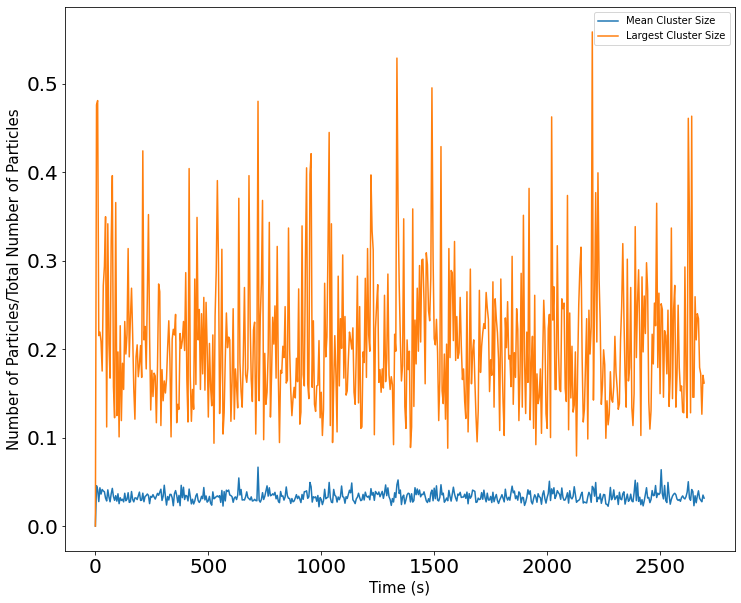

Run:  2


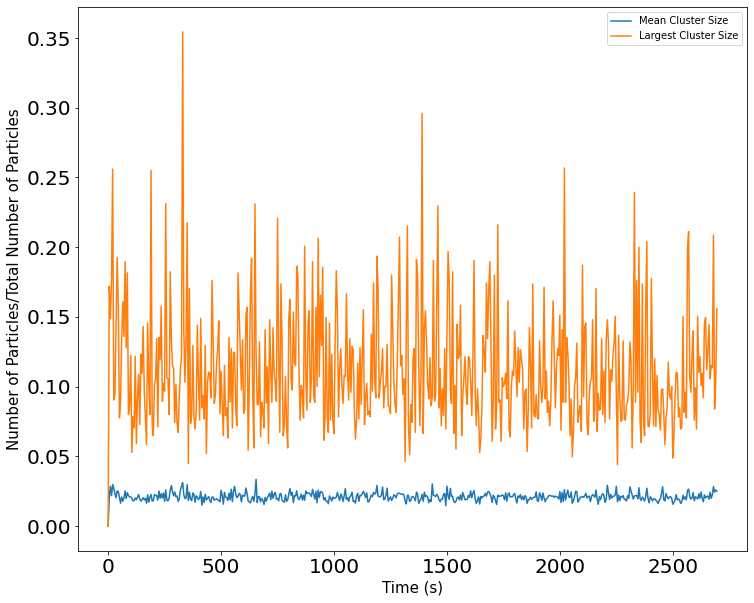

Run:  3


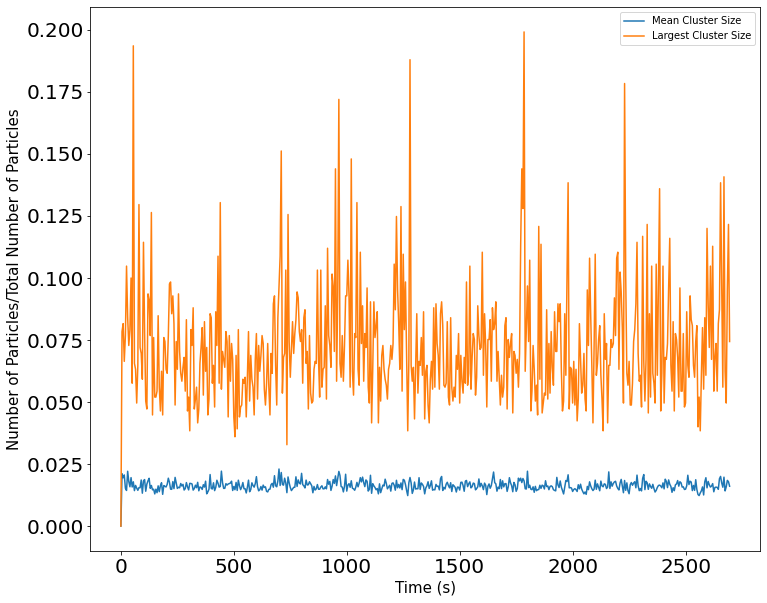

Run:  4


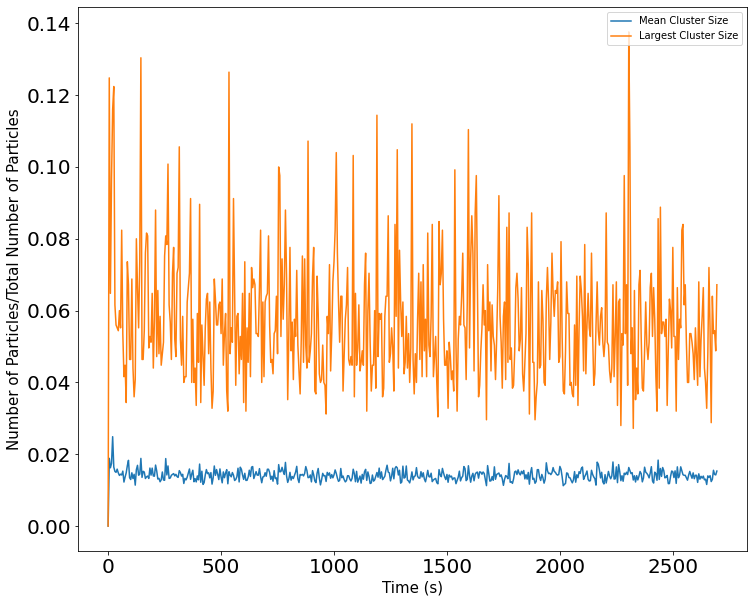

Run:  5


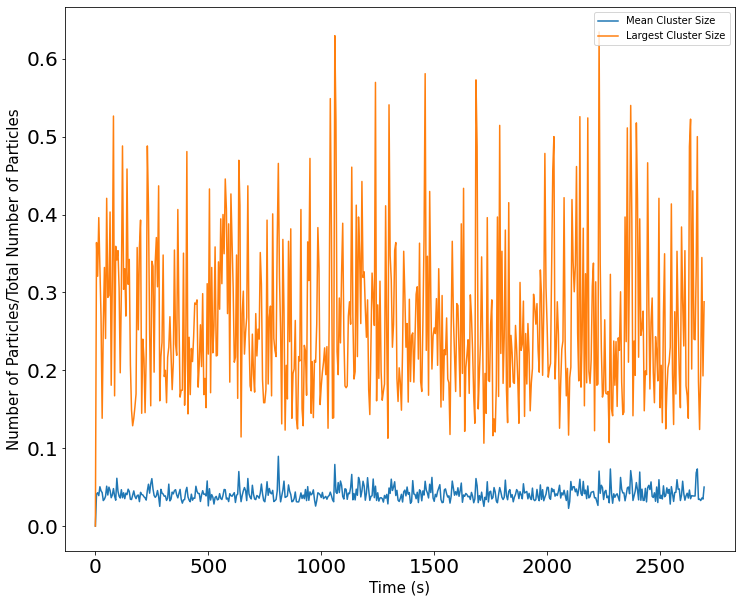

Run:  6


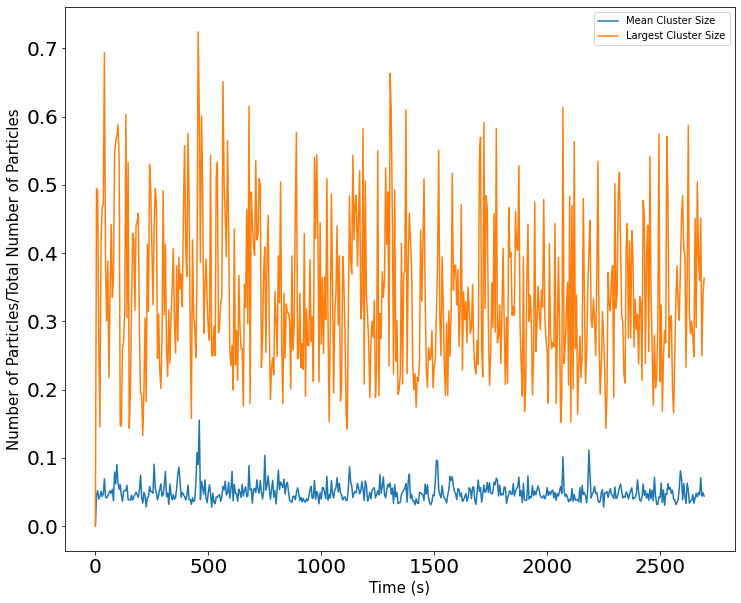

In [14]:
#Plot Transience for a given run

run_numbers=[1,2,3,4,5,6]

for j in run_numbers:
    for i in range(num_runs):
        if run_index[i]==j:
            index=i
            break

    print('Run: ', run_index[index])

    times=Times[index]
    mean_cluster_size=Mean_Cluster_Size[index]
    largest_cluster_size=Largest_Cluster_Size[index]
    num_clusters=Num_Clusters[index]

    g_r=np.array(G_r[index])
    g_t=np.array(G_t[index])
    g_r_abs=np.array(G_r_abs[index])
    g_t_abs=np.array(G_t_abs[index])
    g_r[g_r==0]=np.nan
    g_t[g_t==0.]=np.nan
    g_r_abs[g_r_abs==0]=np.nan
    g_t_abs[g_t_abs==0]=np.nan


    p_rel=np.array(P_rel[index])
    q_rel=np.array(Q_rel[index])
    q_global=Q_global[index]
    p_rel[p_rel<0.05]=np.nan
    q_rel[q_rel<0.05]=np.nan


    #fig,ax1 = plt.subplots(figsize=(12,10))
    #ax2= ax1.twinx()
    #ax1.plot(times,mean_cluster_size,label='Mean Cluster Size')
    #ax1.plot(times,largest_cluster_size,label='Largest Cluster Size')
    #ax2.plot(times, num_clusters, label='Number of Clusters', color='green')
    #ax1.set_xlabel('Time (s)', size=15)
    #ax1.set_ylabel('Number of Particles / Total Number Particles')
    #ax2.set_ylabel('Number of Clusters')
    #fig.legend(loc='upper right',borderaxespad=5)
    
    plt.figure(figsize=(12,10))
    plt.plot(times,mean_cluster_size,label='Mean Cluster Size')
    plt.plot(times,largest_cluster_size,label='Largest Cluster Size')
    plt.xlabel('Time (s)', size=15)
    plt.ylabel('Number of Particles/Total Number of Particles', size=15)
    plt.legend(loc='upper right')
    plt.xticks(size = 20)
    plt.yticks(size = 20)


    #plt.figure(figsize=(12,10))
    #plt.plot(times, g_r, label='Orientation Clustering Mechanism')
    #plt.plot(times, g_t, label='Velocity Clustering Mechanism')
    #plt.plot(times, g_r_abs, label='Absolute Orientation Clustering Mechanism')
    #plt.plot(times, g_t_abs, label='Absolute Velocity Clustering Mechanism')
    #plt.xlabel('Time (s)', size=15)
    #plt.legend(loc='upper right')

    #plt.figure(figsize=(12,10))
    #plt.plot(times, q_rel, label='Cluster Spatial Arrangement')
    #plt.plot(times, p_rel, label='Cluster Orientation Alignment')
    #plt.plot(times, q_global, label='Global Spatial Arrangement')
    #plt.xlabel('Time (s)', size=15)
    #plt.legend(loc='upper right')

    plt.show()


In [9]:
#Output SS Values

run_numbers=[1,2,3,4,5,6]

for j in run_numbers:
    for i in range(len(run_index)):
        if run_index[i]==j:
            index=i
            break

    print('Run: ', run_index[index])
    
    

    print('Mean Cluster Size', SS_Mean_Cluster_Size[index])
    print('Largest Cluster Size', SS_Largest_Cluster_Size[index])
    print('Number of Clusters', SS_Num_Clusters[index])
    print('Number of Inner Particles', SS_Num_Inner_Particles[index])

    print('Cluster Orientation Alignment', SS_P_rel[index])
    print('Cluster Spatial Arrangement', SS_Q_rel[index])
    print('Global Spatial Arrangement', SS_Q_global[index])

    print('Orientation Mechanism', SS_G_r[index])
    print('Velocity Mechanism', SS_G_t[index])
    print('Absolute Orientation Mechanism', SS_G_r_abs[index])
    print('Absolute Velocity Mechanism', SS_G_t_abs[index])



    print('')

    print(SS_Mean_Cluster_Size[index])
    print(SS_Largest_Cluster_Size[index])
    print(SS_Num_Clusters[index])
    print(SS_Num_Inner_Particles[index])

    print(SS_P_rel[index])
    print(SS_Q_rel[index])
    print(SS_Q_global[index])

    print(SS_G_r[index])
    print(SS_G_t[index])
    print(SS_G_r_abs[index])
    print(SS_G_t_abs[index])

Run:  1
Mean Cluster Size 0.03374843076238421
Largest Cluster Size 0.20790444444444445
Number of Clusters 24.16111111111111
Number of Inner Particles 0.0
Cluster Orientation Alignment 0.39002783628553744
Cluster Spatial Arrangement 0.5941292200828149
Global Spatial Arrangement 0.5758399939592433
Orientation Mechanism -0.022079199948013623
Velocity Mechanism -0.015983430774897712
Absolute Orientation Mechanism 0.9225264136971938
Absolute Velocity Mechanism 0.9252577463340202

0.03374843076238421
0.20790444444444445
24.16111111111111
0.0
0.39002783628553744
0.5941292200828149
0.5758399939592433
-0.022079199948013623
-0.015983430774897712
0.9225264136971938
0.9252577463340202
Run:  2
Mean Cluster Size 0.020999849503786226
Largest Cluster Size 0.11073555555555556
Number of Clusters 35.30277777777778
Number of Inner Particles 0.0
Cluster Orientation Alignment 0.4113711642940653
Cluster Spatial Arrangement 0.5912155095306301
Global Spatial Arrangement 0.5792672919209041
Orientation Mechanism

Run Number 3
Np 1250
Box Length 186
Self Propulsion 6.86


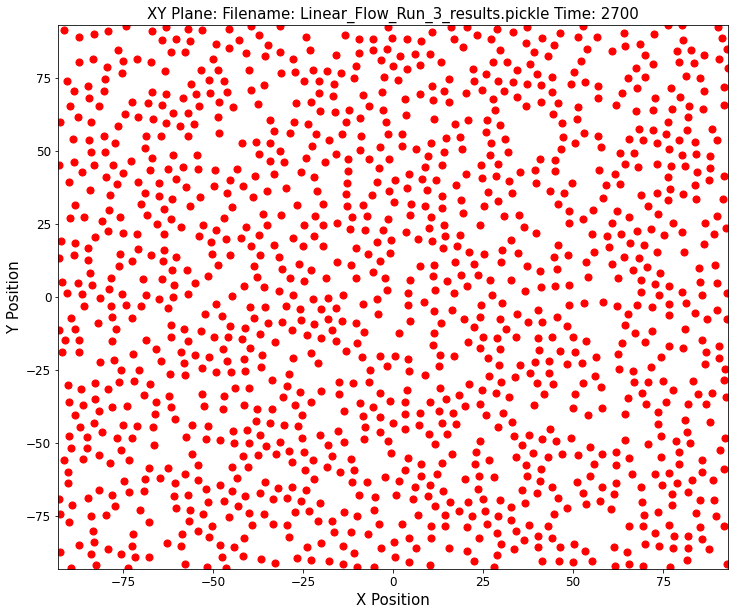

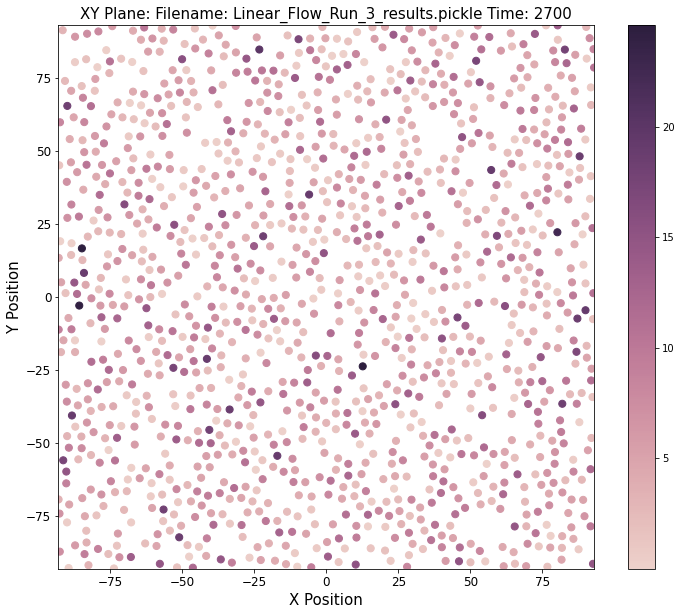

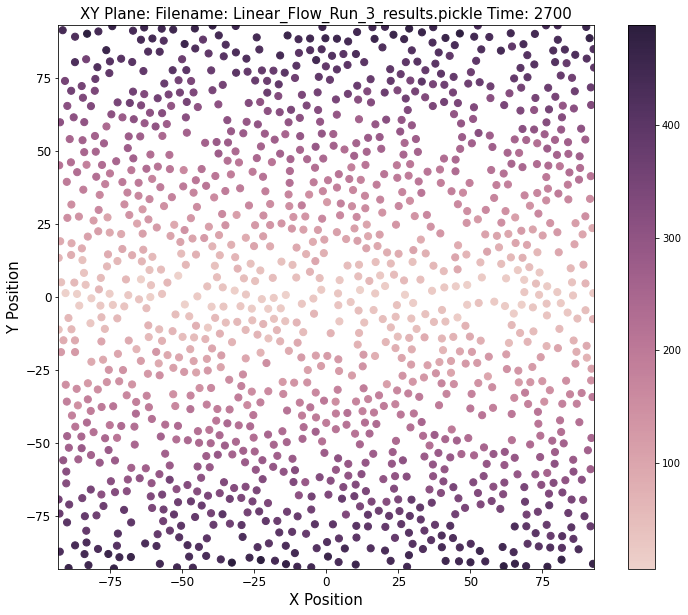

Run Number 6
Np 1250
Box Length 186
Self Propulsion 6.86


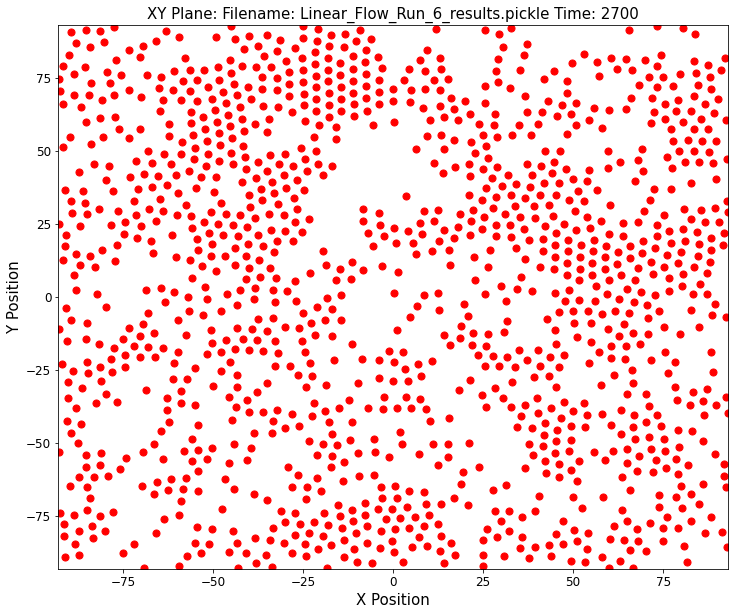

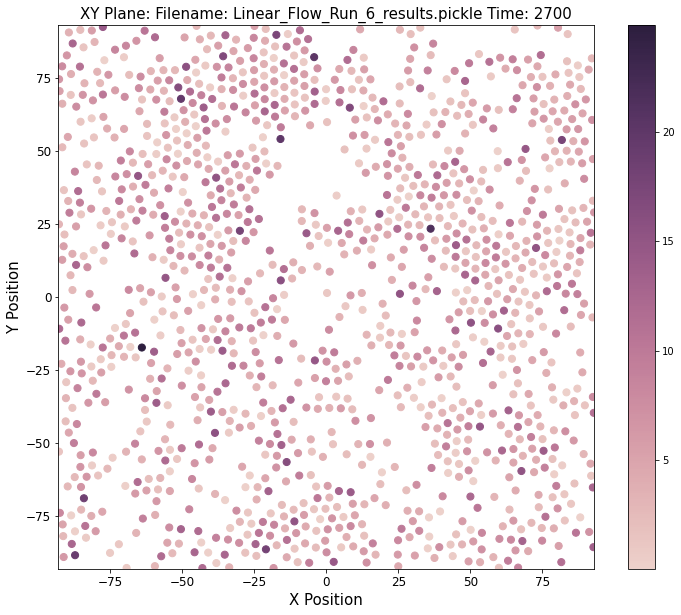

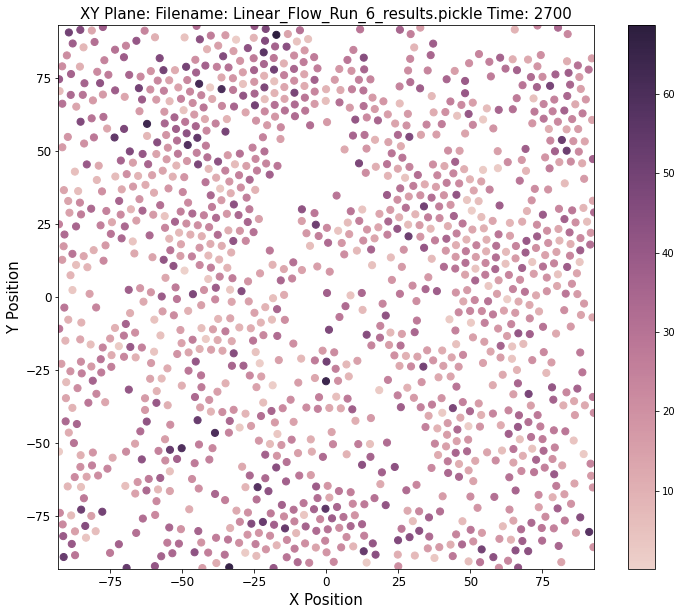

In [23]:
run_numbers=[3,6]
times=[2700]

for j in run_numbers:
    for i in range(len(run_index)):
        if run_index[i]==j:
            index=i
            break


    for i in range(len(times)):
        t=times[i]
        simulation_info=master_data_simulation_info[index]
        results_info=master_data_results[index]
        
        print('Run Number', j)
        print('Np', simulation_info['Np'])
        print('Box Length', simulation_info['box_length'])
        print('Self Propulsion', simulation_info['vp'])

        plot_positions_2D(simulation_info=simulation_info,results_info=results_info, t=t,x_axis_lim=False,y_axis_lim=False, 
                          x_axis_min=-10,x_axis_max=10,y_axis_min=-10,y_axis_max=10,)
        
        plot_positions_2D_Angular_Speed(simulation_info=simulation_info,results_info=results_info, t=t,x_axis_lim=False,y_axis_lim=False, 
                                      x_axis_min=-10,x_axis_max=10,y_axis_min=-10,y_axis_max=10,)
        
        plot_positions_2D_Speed(simulation_info=simulation_info,results_info=results_info, t=t,x_axis_lim=False,y_axis_lim=False, 
                                x_axis_min=-10,x_axis_max=10,y_axis_min=-10,y_axis_max=10,)

        #plot_field(simulation_info=simulation_info,results_info=results_info, Field_HI=True,Field_Flow=False,
        #           Field_Phoresis_Active=False,Field_Phoresis_Passive=False,
        #           t=t,L=20, Ng=10, x_axis_lim=False, y_axis_lim=False,
        #           x_axis_min=900,x_axis_max=1100,y_axis_min=-70,y_axis_max=1000)
        
        plt.show()

In [25]:
run_numbers=[1,3,4,5,6,7,8,9,10]

for j in run_numbers:
    for i in range(len(run_index)):
        if run_index[i]==j:
            index=i
            break
            
    simulation_info=master_data_simulation_info[index]
    results_info=master_data_results[index]
    dXdt=results_info['dXdt']
    times=results_info['times']
    Np=simulation_info['Np']
    average_dpdt_timestep=[]
    for i in range(0,len(times),10):
        average_dpdt_particles=[]
        for k in range (Np):
            angular_speed=np.sqrt(dXdt[i][2*Np+k]*dXdt[i][2*Np+k]+dXdt[i][3*Np+k]*dXdt[i][3*Np+k])
            average_dpdt_particles.append(angular_speed)
        average_dpdt_timestep.append(np.mean(average_dpdt_particles))
    print('Run Number: ', j, 'Average dpdt: ', np.mean(average_dpdt_timestep))  

Run Number:  1 Average dpdt:  5.136301485683381
Run Number:  3 Average dpdt:  5.120918100752969
Run Number:  4 Average dpdt:  5.133809725894742
Run Number:  5 Average dpdt:  5.116931647253379
Run Number:  6 Average dpdt:  5.110721734827715
Run Number:  7 Average dpdt:  5.12096979109239
Run Number:  8 Average dpdt:  5.124269687993149
Run Number:  9 Average dpdt:  5.118289936440521
Run Number:  10 Average dpdt:  5.120019819657338


In [17]:
run_numbers=[1,3,4,5,6,7,8,9,10]

for j in run_numbers:
    for i in range(len(run_index)):
        if run_index[i]==j:
            index=i
            break
            
    simulation_info=master_data_simulation_info[index]
    results_info=master_data_results[index]
    dXdt=results_info['dXdt']
    times=results_info['times']
    Np=simulation_info['Np']
    average_v_timestep=[]
    for i in range(0,len(times),10):
        average_v_particles=[]
        for k in range (Np):
            speed=np.sqrt(dXdt[i][k]*dXdt[i][k]+dXdt[i][Np+k]*dXdt[i][Np+k])
            average_v_particles.append(speed)
        average_v_timestep.append(np.mean(average_v_particles))
    print('Run Number: ', j, 'Average speed: ', np.mean(average_v_timestep))  

Run Number:  1 Average speed:  18.580883155557316
Run Number:  2 Average speed:  18.611324827264497
Run Number:  3 Average speed:  18.741488678509608
Run Number:  4 Average speed:  18.93122503471565
Run Number:  5 Average speed:  19.576802409734515
Run Number:  6 Average speed:  18.581290797106977
Run Number:  7 Average speed:  18.618841110901425
Run Number:  8 Average speed:  18.731786758087928
Run Number:  9 Average speed:  18.919781615604613
Run Number:  10 Average speed:  19.54904407760579
Run Number:  11 Average speed:  18.57338061121509
Run Number:  12 Average speed:  18.613814087244602
Run Number:  13 Average speed:  18.739233876024336
Run Number:  14 Average speed:  18.91848736381565
Run Number:  15 Average speed:  19.53931203572947
